# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from numpy.random import default_rng

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
#list_path_database = [path_shared + 'Database/']   # tabulated phases
list_path_database = [path_shared + 'Database16_42/']   # tabulated phases

### Output ###
subfolder_output = 'Poisson/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script

paths_to_create_delete = [path_figures]

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database16_42/'
Total number of phases: 436


# Build synthetic XRD pattern

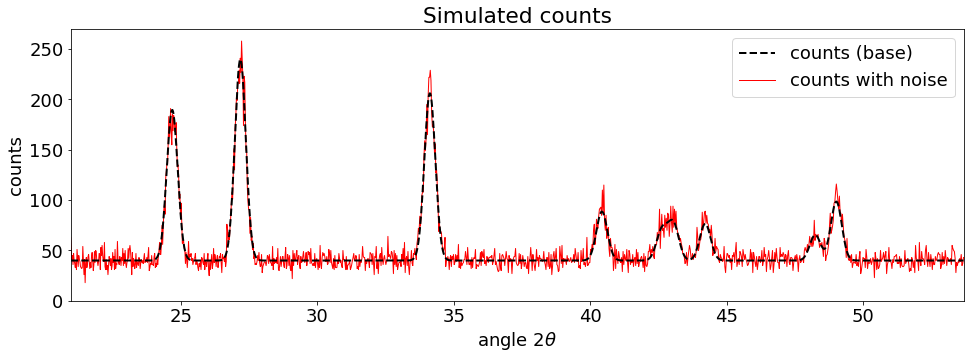

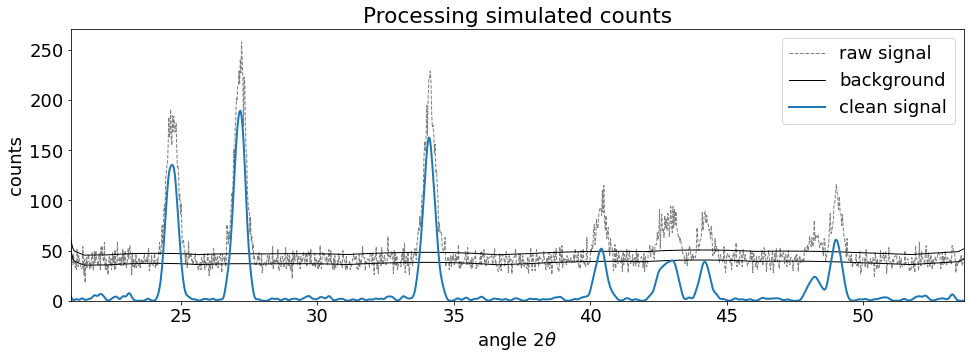

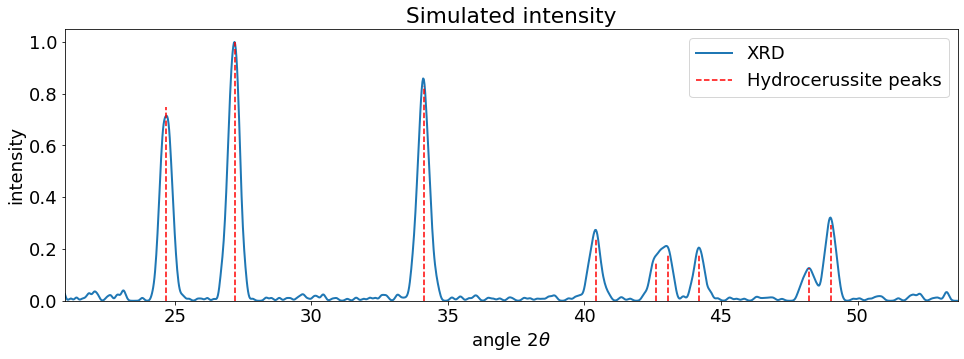

In [5]:
rcParams['font.size'] = 18

phase_chosen = database['Hydrocerussite'][0]

### Parameters to select peaks of the chosen phase ###
min_theta = 21
max_theta = 50
min_intensity = 0.1
first_n_peaks = None
sigma = 0.2   # choose width of the peaks

### Parameters to simulate measured values ###
counts_max = 200
counts_background = counts_max / 5

### Parameters for smoothing ###
window_snip = 32         # width of the window used for determining the background (default 32)
offset_background = 10   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3           # degree of the final smooth applied to the XRD pattern (default 0)



###

n_channels = 1280
calibration_right = array([-1172.8, 2053.1, 50.710])

gn_dummy = GaussNewton(phase_chosen, SpectraXRD().from_array(ones(n_channels)).calibrate_from_parameters(calibration_right),
    min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

counts = (counts_max * gn_dummy.z())
counts_with_background = counts + counts_background
rng = default_rng()
counts_with_noise = rng.poisson(lam = counts_with_background, size = None)

spectrum_built = (
    FastSpectraXRD()
    .from_array(counts_with_noise.astype(int))
    .calibrate_from_parameters(calibration_right)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)


fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_built.theta, counts_with_background, lw = 2, ls = '--', c = 'black', zorder = 2, label = 'counts (base)')
ax.plot(spectrum_built.theta, spectrum_built.counts, lw = 1, ls = '-', c = 'red', zorder = 1, label = 'counts with noise')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(*spectrum_built.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('counts')
ax.set_title('Simulated counts')
show()

fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_built.theta, spectrum_built.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_built.theta, spectrum_built.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_built.theta, spectrum_built.background + spectrum_built.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_built.theta, spectrum_built.counts_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(*spectrum_built.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('counts')
ax.set_title('Processing simulated counts')
show()

fig, ax = subplots(figsize = (16, 5))
sca(ax)
spectrum_built.plot(lw = 2, label = 'XRD')
phase_chosen.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
                  first_n_peaks = first_n_peaks, sigma = sigma, label = phase_chosen.label + ' peaks')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(*spectrum_built.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('intensity')
ax.set_title('Simulated intensity')
show()

# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [6]:
elements_chosen = ['Pb']
elements_excluded = []

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        
        # Change 'all' (the first) into 'any' if you want to select phases that have at least one of elements_chosen
        
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,(Pb O) (Pb (Cr O4)),Cr O5 Pb2,1
1,Anglesite,O4 Pb S,5
2,Cerussite,C O3 Pb,6
3,Crocoite,Cr O4 Pb,3
4,Hydrocerussite,C H O4 Pb1.5,1
5,Lead,Pb,5
6,Lead Chromate Oxide,Cr O5 Pb2,1
7,Lead Monoxide,Pb O,2
8,Lead carbonate,Pb C O3,1
9,Lead-tin yellow,Pb2 Sn O4,1


### Fit selected phases on experimental XRD pattern

In [10]:
phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True), ('overlap_area_ratio', False), ('adjustment_ratio', False)

###

list_presence = []
list_presence_avg = []
list_presence_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    
    gs = GammaSearch([p for p in phase_set], spectrum_built, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gs = gs.fit_cycle(gamma = True, steps = 16)
    presence = gs.phase_presence(method = phase_presence_method, correction = phase_presence_correction)
    list_presence.append(presence)

df_phases['Best presence'] = [nanmax(list_presence[i]) for i in range(df_phases.shape[0])]
(df_phases
 .sort_values(by = ['Best presence'], ascending = False)
 .reset_index(drop = True)
 .style.format({'Best presence': '{:.3f}'}))

,Name in database,Chemical formula,N. of samples,Best presence
0,hydrocerussite,C2 H2 O8 Pb3,1,0.798
1,Hydrocerussite,C H O4 Pb1.5,1,0.798
2,V LeadSulfate,Pb S O4,2,0.435
3,V Lead carbonate,C O3 Pb,1,0.264
4,Crocoite,Cr O4 Pb,3,0.204
5,Lead carbonate,Pb C O3,1,0.166
6,Pb (Cr O4),Cr O4 Pb,1,0.150
7,Cerussite,C O3 Pb,6,0.147
8,Anglesite,O4 Pb S,5,0.132
9,Minium,O4 Pb3,10,0.119


### Select phase samples
If the presence of a phase is above `threshold_presence`, the phase is selected.

In [11]:
threshold_presence = 0.2

list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_presence = []

for i in range(df_phases.shape[0]):
    idx = (list_presence[i] >= threshold_presence)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_presence_filtered = list_presence[i][idx]
        j = nanargmax(arr_presence_filtered)
        
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_presence.append(arr_presence_filtered[j])

df_phases_sel = DataFrame({
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Presence': list_sel_presence,
})
df_phases_sel = df_phases_sel.sort_values(by = 'Presence', ascending = False).reset_index(drop = True)
df_phases_sel.style.format({'Presence': '{:.3f}'})

,Phase,Formula,Sample,Presence
0,Hydrocerussite,C H O4 Pb1.5,0,0.798
1,hydrocerussite,C2 H2 O8 Pb3,0,0.798
2,V LeadSulfate,Pb S O4,0,0.435
3,V Lead carbonate,C O3 Pb,0,0.264
4,Crocoite,Cr O4 Pb,2,0.204


# List of phases vs experimental XRD pattern

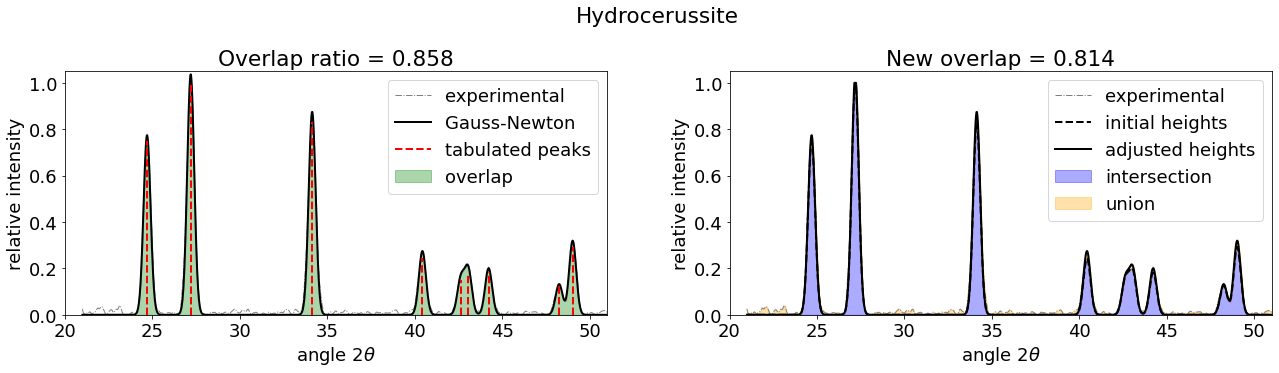

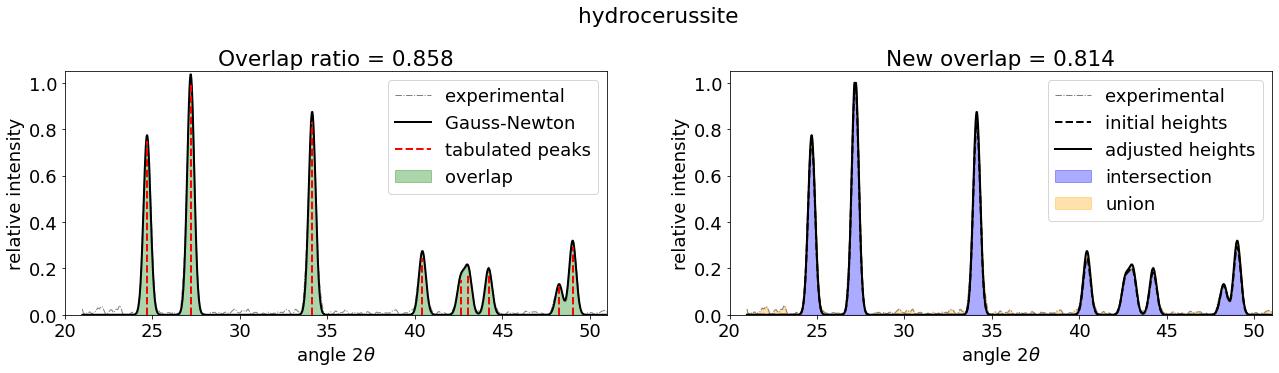

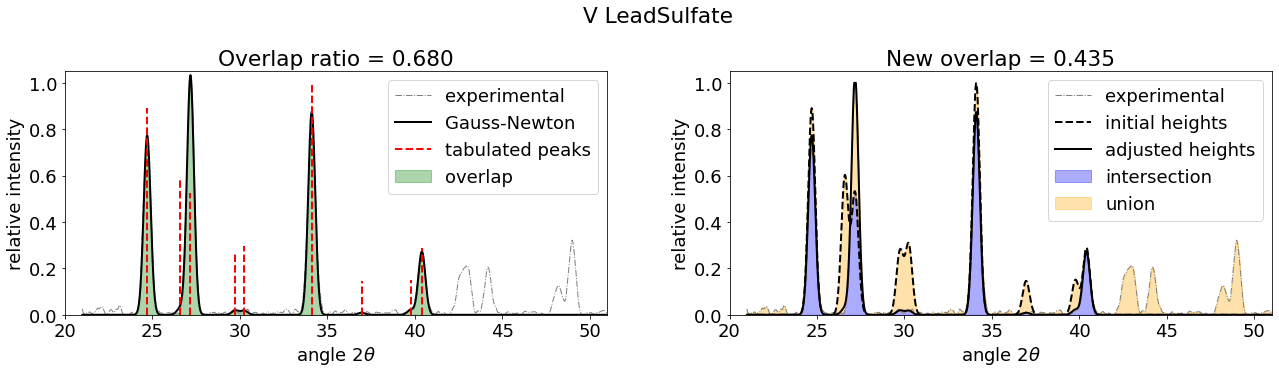

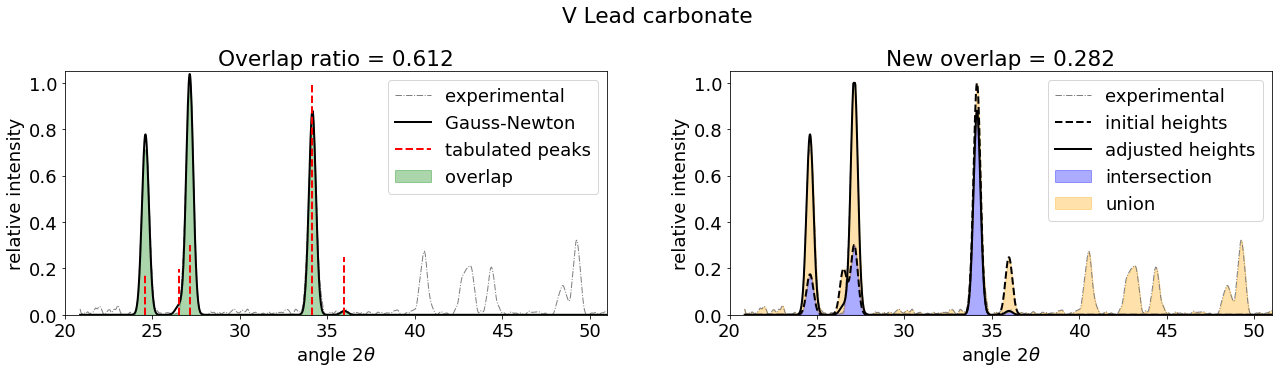

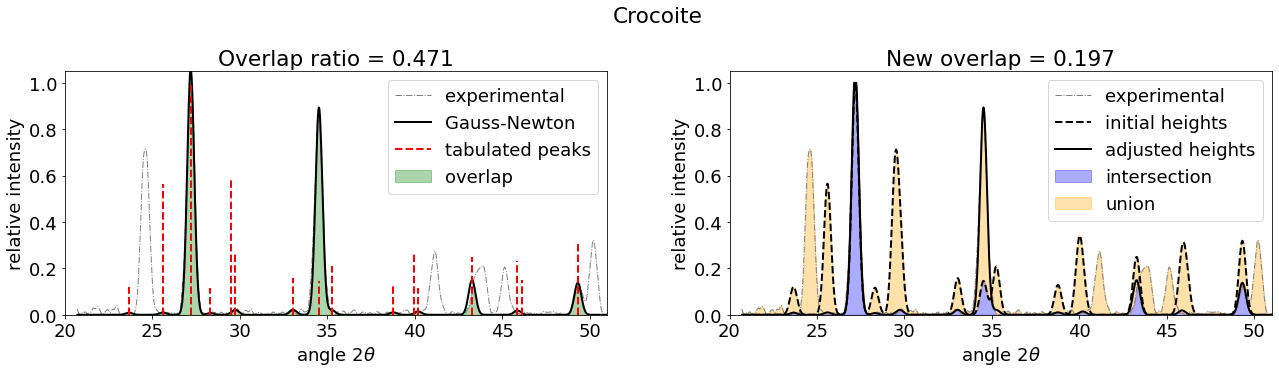

In [17]:
rcParams['font.size'] = 18

### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Lazurite'][0]
phase_calibration = None

###

for i in range(df_phases_sel.shape[0]):
    
    ### Fit ###
    
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase_check = database[phase_name][phase_sample]

    gn = GaussNewton(phase_check, spectrum_built, min_theta = min_theta, max_theta = max_theta,
                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    
    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, spectrum_built, min_theta = min_theta, max_theta = max_theta,
                                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
        gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 32)
        gn.opt = gn_calibration.opt.copy()
    
    gn.fit_cycle(gamma = True, steps = 16)
    
    z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from presenceping tabulated peaks
    z = clip(gn.z(), None, 1)
    z_stack = stack((z0, z, gn.intensity))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    presence = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.phase.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
        first_n_peaks = first_n_peaks, sigma = sigma, lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')
    
    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {presence:.3f}')
    
    fig.suptitle(phase_name)
    
    savefig(f'{path_figures}{clean_phase_name(phase_name)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Select peaks in phase

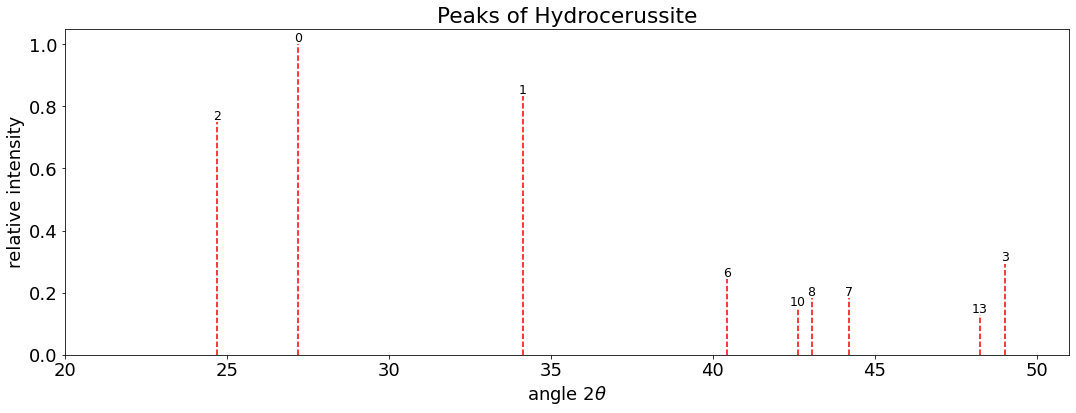

In [14]:
rcParams['font.size'] = 18

phase = database['Hydrocerussite'][0]
peaks_selected = None#[i for i in range(15) if i != 3] # Put 'None' or empty list to select all the peaks

phase.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
phase.select_peaks(peaks_selected)

fig, ax = subplots(figsize = (18, 6))
sca(ax)
phase.plot(positions = True, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Peaks of {phase.label}')
show()

# Phase search and match

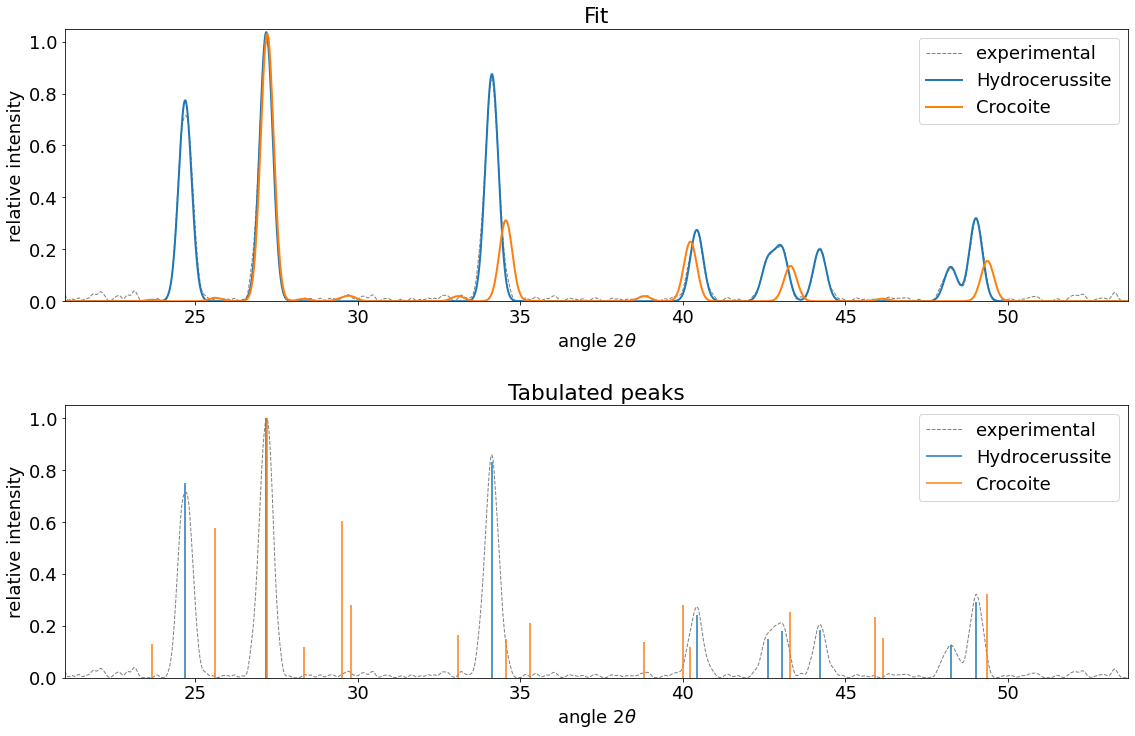

In [15]:
### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = database['Hydrocerussite'][0]


### Visualization parameters ###
rcParams['font.size'] = 18

# List of phases that will be checked against the experimental XRD pattern
#list_phases_check = [ database[df_phases_sel.loc[i, 'Phase']][df_phases_sel.loc[i, 'Sample']] for i in range(df_phases_sel.shape[0]) ]
list_phases_check = [ database['Hydrocerussite'][0], database['Crocoite'][0] ]

# The diffraction lines of this phase will be shown for comparison. Set to empty list in order to have no comparison.
#list_phases_comparison = [database['Wollastonite-2M'][0]]
list_phases_comparison = []


###

gs = GammaSearch(list_phases_check, spectrum_built, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_built, min_theta = min_theta, max_theta = max_theta,
                                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gs.set_opt(gn_calibration.opt.copy())

gs.fit_cycle(gamma = True, steps = 32)


### Plot ###

fig, axs = subplots(2, 1, figsize = (16, 10))
fig.tight_layout(h_pad = 4)
cmap_sel = cm.get_cmap('tab10')

ax = axs[0]
sca(ax)
gs[0].plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
for i, gn in enumerate(gs):
    idx_color = i % cmap_sel.N
    ax.plot(gn.theta, gn.z(), lw = 2, color = cmap_sel(idx_color), label = shorten_string(gn.label, 30))
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(gn.theta_range())
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title('Fit')

ax = axs[1]
sca(ax)
gs[0].plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
for i, phase in enumerate([gn.phase for gn in gs] + list_phases_comparison):
    idx_color = i % cmap_sel.N
    phase.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks,
        sigma = sigma, colors = cmap_sel(idx_color), linestyles = '-', label = shorten_string(phase.label, 30))
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(gn.theta_range())
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title('Tabulated peaks')

savefig(f'{path_figures}phases search match.png', bbox_inches = 'tight', dpi = 300)
show()